# Probabilistic Programming
## Introduction

So far you've been doing all your calculations by hand. As you have probably learned, this is timeconsuming and error prone. In this minicourse, we are going to automate some of this labour. The framework of defining a probabilistic model and automatically inferring variables of interest is called _Probabilistic Programming_. Within probabilistic programming, there are two schools of thought: Monte Carlo Sampling and Variational Inference. We will briefly discuss both.

## Monte Carlo Sampling

We are often interested in expected values of posterior distributions: $\int g(\theta) p(\theta | x) d\theta$. However, in most cases, one _cannot_ integrate with respect to the posterior distribution. We _can_, however, approximate the expected value numerically. In Monte Carlo sampling, you draw samples from the distribution and compute the sample average. This is motivated by the [Law of Large Numbers](https://www.statlect.com/asymptotic-theory/law-of-large-numbers), stating that sample averages converge to expected values as the sample size goes to infinity. The tricky question now becomes: _how_ do we draw samples from a distribution of interest?

Let's start with an example. Suppose we have a data set $x = (x_1, \dots, x_n)$ for $n = 10$.

In [1]:
x = [ 1.933941003333588   
      1.2906861713484055  
      2.1557425895881344  
     -0.19577699840304308 
      1.9286333440526109  
      1.348547825603848   
      1.601097022550203   
      1.3930768157194358  
      1.5423374500522113  
      0.020411639519813063];

We assume that these samples are drawn from a Gaussian likelihood with unknown mean and precision parameter: $\mathcal{N}(x \mid \mu, \tau^{-1})$. Being Bayesians, we put a prior on the unknown parameters, in the form of a [Normal-Gamma distribution](https://en.wikipedia.org/wiki/Normal-gamma_distribution): 

$$\mathcal{NG}\ (\mu, \tau \mid m, l, a, b) = \frac{b^{a}\sqrt{l}}{\Gamma(a)\sqrt{2\pi}} \tau^{a- 1/2} \exp(-b \tau) \exp \big(-\frac{1}{2} l \tau (\mu - m)^2 \big)\, .$$

We set the prior's parameters to particular values, $m_0=0$, $l_0=1$, $a_0=1$ and $b_0=1/2$ (the subscript \_0 indicates that these are the parameters of the prior and that they have been set), and visualize the bivariate distribution:

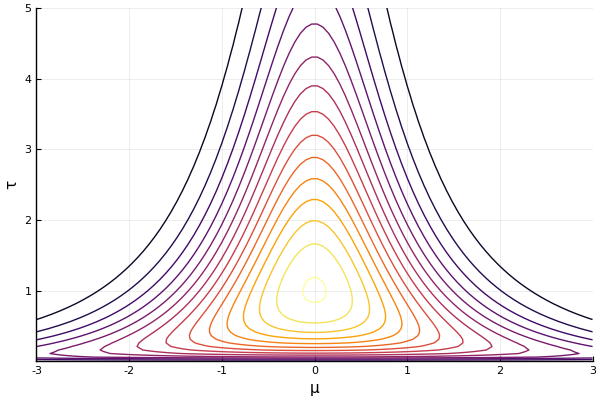

In [2]:
using Logging; disable_logging(LogLevel(0))
using Distributions
using Plots; pyplot()
include("../scripts/pp-1.jl")

# Prior parameters
m_0 = 0
l_0 = 1
a_0 = 1
b_0 = 1/2

# Visualize prior
plot_normalgamma(m_0, l_0, a_0, b_0, 
                 x1=range(-3, stop=3, length=100), 
                 x2=range(0.01, stop=5, length=100))

The posterior distribution for the parameters $\mu$ and $\tau$ is proportional to the likelihood of the $n$ samples times the prior distribution:

$$ p(\mu, \tau \mid x) \propto \prod_{i=1}^{n} \mathcal{N}(x_i \mid \mu, \tau^{-1}) \ \mathcal{NG}\ (\mu, \tau \mid m_0, l_0, a_0, b_0) \, .$$

In fact, because the Normal-Gamma distribution is the conjugate prior to the Gaussian likelihood, the posterior is proportional to a Normal-Gamma distribution as well: $p(\mu, \tau \mid x) \propto \mathcal{NG}\ (\mu, \tau \mid m, l, a, b)$. It has the following parameters:

$$ \begin{align} m =& \ \frac{l_0 m_0 + n\bar{x}}{l_0+n} \\
    l =& \ l_0 + n \\
    a =& \ a_0 + \frac{n}{2} \\
    b =& \ b_0 + \frac{1}{2} \big(n \bar{\bar{x}} + \frac{l_0n(\bar{x} - m_0)^2}{l_0+n} \big) \end{align} $$


where $\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i$ and $\bar{\bar{x}} =  \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2$. Visualizing this, we see that the posterior has shifted away from the prior. 

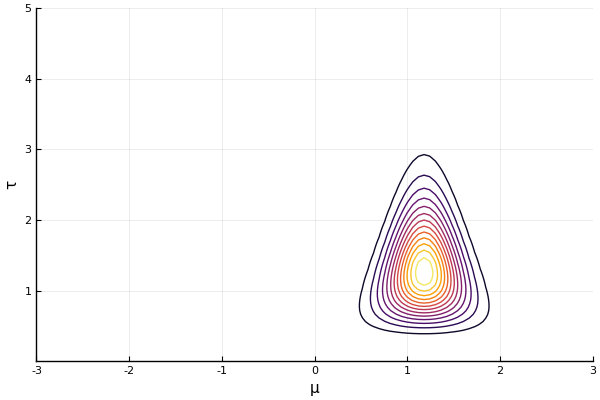

In [3]:
# Convenience variables
n = length(x)
x_ = mean(x)
x__ = var(x)

# Parameters of the posterior
m = (l_0 * m_0 + n*x_)/(l_0 + n)
l = l_0 + n
a = a_0 + n/2
b = b_0 + 1/2*(n*x__ + (l_0*n*(x_ - m_0)^2)/(l_0 + n))

# Visualize prior
plot_normalgamma(m, l, a, b, 
                 x1=range(-3, stop=3, length=100), 
                 x2=range(0.01, stop=5, length=100))


#### Gibbs sampling

We want to know the expected value of this posterior, which we can obtain via Monte Carlo sampling. There are many types of "samplers", each with their own strenghts and limitations. Here, we will use a _Gibbs sampler_. It decomposes a multivariate distribution into simpler conditional distributions and samples from each of them sequentially. In this example, we factorize the posterior into the following two conditional distributions:

$$ \mathcal{NG}\ \big(\mu, \tau \mid m, l, a, b \big) = \mathcal{N}( \mu \mid m, (l\tau)^{-1}) \ \Gamma(\tau \mid a, b) \, .$$

We draw a sample from $\theta_1^t \sim \Gamma(\tau \mid a,b)$ and use _that_ sample to draw a sample from $\theta_2^t \sim \mathcal{N}( \mu \mid m, (l\theta_1^t)^{-1})$. Together these two samples from a sample from the full posterior distribution, $\theta^t = [\theta_1^t \ \theta_2^t]$. We repeat this sampling procedure for $t = 1, \dots T$ and then compute the sample average to obtain the expected value of the full posterior.

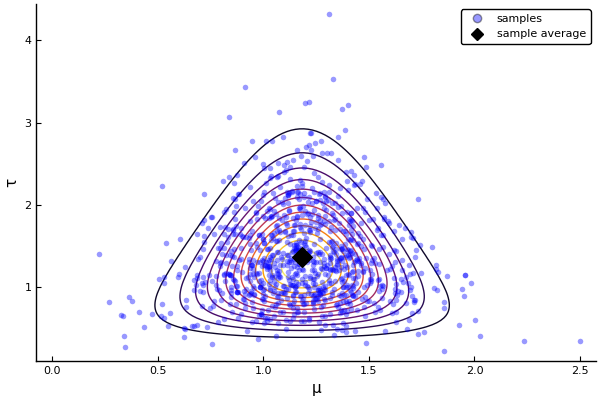

In [4]:
# Total number of samples to draw
T = 1000

# Preallocate array
samples = zeros(T, 2)

for t = 1:T
    
    # Draw a sample from G(τ | a, 1/b) (1/b is necessary because Distributions.jl uses a shape-scale parameterization instead of a shape-rate)
    samples[t,1] = rand(Gamma(a, 1/b), 1)[1]
    
    # Draw a sample from N(μ | m, √(lτ)^-1) (√ is necessary because Distributions.jl uses a tandard deviation parameterization instead of variance)
    samples[t,2] = rand(Normal(m, sqrt(inv(l*samples[t,1]))), 1)[1]
    
end

# Plot posterior distribution
plot_normalgamma(m, l, a, b, 
                 x1=range(0, stop=2, length=100), 
                 x2=range(0.3, stop=3, length=100))

# Scatter samples
scatter!(samples[:,2], samples[:,1], label="samples", markershape=:circle, color="blue", markerstrokewidth=0, alpha=0.4)

# Sample average
μ_hat = mean(samples[:,2], dims=1)
τ_hat = mean(samples[:,1], dims=1)

scatter!(μ_hat, τ_hat, label="sample average", markershape=:diamond, markersize=10, color="black", grid=false)

### Markov Chain Monte Carlo

The above procedure demonstrates the general principle by which Monte Carlo sampling approximates expected values of distributions we cannot integrate. In the example, we used Gibbs sampling. Note that we used a sample drawn from one of the conditional distributions, namely $\theta_1^t \sim \Gamma(\tau \mid a,b)$, to draw a sample from the other conditional distribution, namely $\theta_2^t \sim \mathcal{N}( \mu \mid m, (l\theta_1^t)^{-1})$. This form of sampling, Gibbs sampling, is an example of a _Markov Chain_ Monte Carlo sampling procedure. In MCMC sampling, we construct Markov chains (i.e. random walks) that converge to a distribution of interest (e.g. posterior distributions). The random walk is guided by the target distribution; it moves to parts of parameter space proportional to the probability of the target distribution. Below, we will visualize this process in more detail.

#### Metropolis-Hastings

Gibbs sampling exploits the fact that conditional distributions have a known parametric form. In our example setting, these were the Gaussian and Gamma distrbutions. In general, you will not find conditional distributions with known forms. In such situations, you can fall back on Metropolis-Hastings sampling. We'll show you how it works by applying it to our example setting.

1) We draw a starting point $\theta^0$ from a starting distribution $p_0(\theta)$

2) We define a "jumping" distribution 

$$J_t(\theta^{*} \mid \theta^{t-1}) = \begin{bmatrix}\Gamma(\theta_1^{*} \mid \theta_1^{t-1}, 1) \\ \mathcal{N}(\theta^{*}_2 \mid \theta_2^{t-1}, 1) \end{bmatrix}$$.

3) We accept a newly sampled point if:

$$ \theta^{t} = \begin{cases} \theta^{*} & \text{with probability} \min(r,1) \\ \theta^{t-1} & \text{otherwise} \end{cases}$$

where $$r = \frac{p(\theta^{*} \mid x)}{p(\theta^{t-1} \mid x)}$$.

In [5]:
# Length of sampling procedure
T = 5000

# I fix the starting point to a particular value for illustration purposes.
θ_0 = [1, 0]

# Define jumping distribution
J_t(θ_tmin) = [rand(Gamma(θ_tmin[1], 1), 1)[1] rand(Normal(θ_tmin[2], 1/4), 1)[1]]

# Define acceptance criterion
r(θ, θ_tmin) = prob_normalgamma(θ[2], θ[1], m=m, l=l, a=a, b=b) / prob_normalgamma(θ_tmin[2], θ_tmin[1], m=m, l=l, a=a, b=b)

# Preallocate samples
samples = zeros(T+1,2)
samples[1,:] = θ_0

# Start sampling procedure
for t = 2:T+1
    
    # Extract θ^t-1 from sample array
    θ_tmin = samples[t-1,:]
   
    # Propose jump
    θ_star = J_t(θ_tmin)
    
    # Compute acceptance probability
    rθ = r(θ_star, θ_tmin)
    
    # Randomly jump
    u = rand(Uniform(0,1), 1)[1]
    if u < min(rθ, 1)
        θ_t = θ_star
    else
        θ_t = θ_tmin
    end
    
    # Store θ^t in sample array
    samples[t,:] = θ_t
    
end

We can animate the random walk as it traverses parameter space.

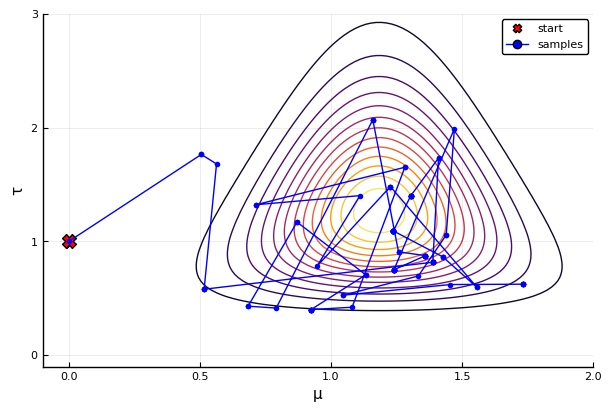

In [6]:
using StatsPlots
 
animation = @gif for t = 1:100
    
    # Plot posterior distribution
    plot_normalgamma(m, l, a, b, 
                     x1=range(0, stop=2, length=100), 
                     x2=range(0.3, stop=3, length=100))

    # Mark starting point
    scatter!([θ_0[2]], [θ_0[1]], label="start", markershape=:xcross, markersize=10, color="red")
    
    # Plot path
    plot!(samples[1:t+1, 2], samples[1:t+1, 1], label="samples", color="blue", markershape=:circle, markerstrokewidth=0) 
    
    xlims!(-0.1, 2)
    ylims!(-0.1, 3)
end;

The samples you've drawn reflect the posterior distribution. But the initial ones are often outliers with respect the target distribution. If you were to run the algorithm for a very long time, these first ones do not affect the sample average too much. For shorter runs, it is often more practical to reject the first few samples. This is called a burn-in. Below, we visually all samples plus the sample average without the burn-in period.

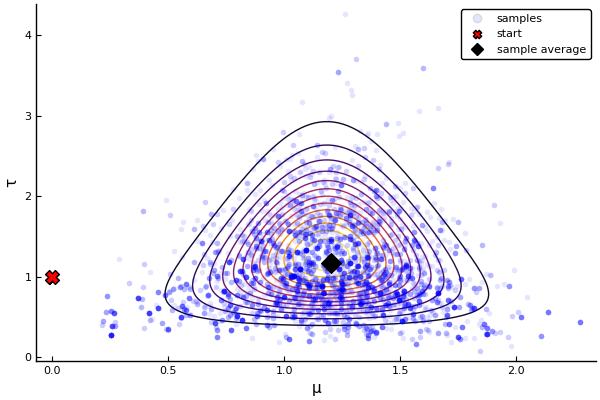

In [7]:
# Plot posterior distribution
plot_normalgamma(m, l, a, b, 
                 x1=range(0, stop=2, length=100), 
                 x2=range(0.3, stop=3, length=100))

# Scatter samples
scatter!(samples[:,2], samples[:,1], label="samples", markershape=:circle, color="blue", markerstrokewidth=0, alpha=0.1)

# Burn-in length
burn = 100

# Sample average
μ_hat = mean(Set(samples[burn:end,2]))
τ_hat = mean(Set(samples[burn:end,1]))

# Mark starting point
scatter!([θ_0[2]], [θ_0[1]], label="start", markershape=:xcross, markersize=10, color="red")

# Mark average of the chain
scatter!([μ_hat], [τ_hat], label="sample average", markershape=:diamond, markersize=10, color="black", grid=false)

Markov Chain Monte Carlo sampling is a powerful tool for approximating expected values of distributions we cannot integrate over. As shown above, we don't need to know the parametric form of the distribution; we can build random walks over parameter space using simple distributions, that are guided by the target distribution. However, there are some limitations to MCMC sampling, most notably when the target distribution has certain "pathological" properties. For example, if the target has two modes that are separated by a region of probability zero, then the walk can't reach both modes. Moreover, it can be difficult to sample from hybrid distributions (i.e. a combination of discrete and continuous variables). 
Finally, as you might imagine, the more complex the target distribution is, the longer it takes for the random walk to cover it. Overall, even though MCMC sampling is the go-to tool for many statisticians, scientists and engineers, but it can be frustatingly slow. 

In this mini-course, you'll use several samplers, such as "Hamiltonian Markov Chain" and "Particle Gibbs". We won't go into them in detail, since they are variants or hybrids of Metropolis-Hastings and Gibbs. Instead, we'll focus on model specification for given problems.

## Variational Inference

Let's quickly recap variational inference by applying it to the above example as well. Remember that the generative model has the form: $p(\mu, \tau \mid x) \propto p(x \mid \mu, \tau) p(\mu, \tau)$. We construct the following recognition distribution to approximate the posterior: $ q(\mu, \tau) = q(\mu) \ q(\tau)$ where 
$$ \begin{align} q(\mu) \sim& \ \mathcal{N}(m_{\mu}, v_{\mu}) \\ q(\tau) \sim& \ \Gamma(a_{\tau}, b_{\tau}) \, . \end{align}$$
If we minimize the variational free energy, 

$$\mathcal{F}[q] = \int q(\mu) q(\tau)\log \frac{q(\mu)q(\tau)}{p(\mu, \tau \mid x)} \mathrm{d}\mu \mathrm{d}\tau \, ,$$

we obtain the following forms for the optimal recognition factors:

$$ \begin{align} q^{*}(\mu) \propto& \ \exp\big(\mathbb{E}_{q(\tau)} [-\log \mathcal{N}(x \mid \mu, \tau)] + \mathbb{E}_{q(\tau)} [-\log \mathcal{NG}\ (\mu, \tau \mid m_0, l_0, a_0, b_0)] \big) \propto \ \mathcal{N}(\mu \mid m_{\mu}^{*}, v_{\mu}^{*}) \\
q^{*}(\tau) \propto& \ \exp \big(\mathbb{E}_{q(\mu)} [-\log \mathcal{N}(x \mid \mu, \tau)] + \mathbb{E}_{q(\mu)} [-\log \mathcal{NG}\ (\mu, \tau \mid m_0, l_0, a_0, b_0)] \big) \propto \Gamma(\tau \mid a_{\tau}^{*}, b_{\tau}^{*}) \end{align}$$

with parameters:

$$ \begin{align}  
m_{\mu}^{*} =& \ (n \bar{x} + l_0 m_0 )\ /\ (n + l_0 ) \\
v_{\mu}^{*} =& \ \big( \frac{a_{\tau}}{b_{\tau}}(n  + l_0) \big)^{-1} \\
a_{\tau}^{*} =& \ a_0 + \frac{n+1}{2} \\ 
b_{\tau}^{*} =& \ b_0 + \frac{1}{2}\big[l_0(m_0^{2} - 2m_0 m_{\mu} + m_{\mu}^2 + v_{\mu}) + n(\tilde{x} - 2 \bar{x} m_{\mu} + m_{\mu}^{2} + v_{\mu})\big]
 \end{align}$$
 
where $\tilde{x} = \frac{1}{n} \sum_{i=1}^{n} x_i^2$. We initialize the recognition distribution's parameters and iteratively update them until convergence.

In [8]:
# Initialize recognition parameters
v_μ = 1
m_μ = 0
a_τ = 1
b_τ = 1

# Iterate update rules
for i = 1:10
    
    m_μ = (n*x_ + l_0*m_0) / (n + l_0)
    v_μ = inv((n + l_0)* a_τ / b_τ)
    a_τ = a_0 + (n+1)/2
    b_τ = b_0 + 1/2*(l_0*(m_0^2 - 2*m_0*m_μ + m_μ^2 + v_μ) + n*(mean(x.^2) -2*mean(x)*m_μ + m_μ^2 + v_μ))
end

We know the expected value of each recognition distribution by virtue of using a known parametric form. In this example, the expected value of the approximate posterior is $[m_{\mu}^{*}\  a_{\tau}^{*} / b_{\tau}^{*}]$, which we know because we chose a Gaussian and a Gamma marginal for the two recognition factors. We can visualize the approximate posterior distribution, along with its expected value:

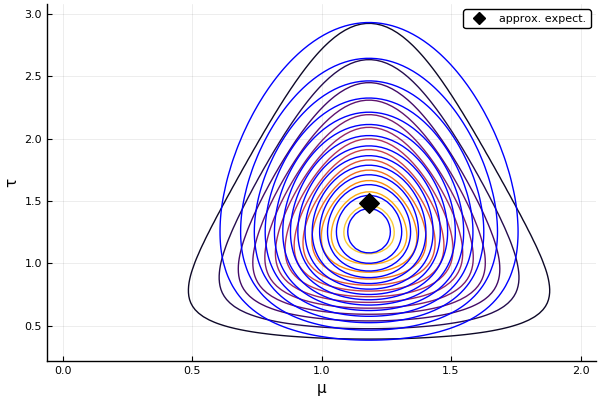

In [9]:
# Plot actual posterior distribution
plot_normalgamma(m, l, a, b, 
                 label="true post.",
                 x1=range(0, stop=2, length=100), 
                 x2=range(0.3, stop=3, length=100))

# Plot approximated posterior distribution
plot_normal_gamma(m_μ, v_μ, a_τ, b_τ, 
                  color="blue",
                  label="approx. post.",
                  x1=range(0, stop=2, length=100), 
                  x2=range(0.3, stop=3, length=100),
                  overlay=true)

scatter!([m_μ], [a_τ/b_τ], label="approx. expect.", markershape=:diamond, markersize=10, color="black")

____________________________

## Outline mini-course PP

We will have four blocks of 2 hours, in wich we work through the following types of models:

1. Regression & Classification
2. Mixture models
3. Hidden Markov models
4. Kalman filters

In each block, we fit the particular probabilistic model using either of the two schools of thought. This results in two notebooks per block: one using MC sampling (e.g. PP-1-sampling) and one using VI (e.g. PP-1-variational). The headers and data generation are equal in both notebooks.

### Model Critiquing & Improvement
It is important to continuously critique and improve your model design. This is daily practice for most data scientists and machine learning engineers. How to critique models is a skill often expected to be obtained through experience; practice makes perfect. However, there are quite a few heuristics that can serve as useful tools in your toolbelt. We will dicuss these throughout the sessions.

## Materials

#### Reading
- [Probabilistic Programming](https://en.wikipedia.org/wiki/Probabilistic_programming)
- [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)
- [Variational Bayesian inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods)
- [Variational inference: a review for statisticians (Blei et al., 2018)](https://arxiv.org/pdf/1601.00670.pdf)
- [Bayesian Data Analysis, 3d ed. (Gelman, Carlin, Stern, Dunson, Vehtari & Rubin, 2013)](http://www.stat.columbia.edu/~gelman/book/)

#### Videos
- [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
- Tips for useful online videos are appreciated.

#### Software
- Multi-language
    - [Stan](https://mc-stan.org/)
- Julia
    - [Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - [ForneyLab.jl](https://biaslab.github.io/forneylab/docs/getting-started/)
- Python
    - [Pyro](http://pyro.ai/)
    - [TensorFlow Probability](https://www.tensorflow.org/probability/)
- MATLAB
    - [Stat & ML Toolbox](https://nl.mathworks.com/products/statistics.html)
- .NET
    - [Infer.NET](https://www.microsoft.com/en-us/research/project/infernet/)